In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import stft
from pzData import pzNpz
from ezPzModels import ezPzAttn

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

In [ ]:
train_labels = "./data/train_labels.csv"
val_labels = "./data/val_labels.csv"
val_dir = test_dir = train_dir = "./data/raw/"

CROP = 15000
cut = lambda x: x[:CROP]

def stfourier(x):
    freq = len(x) // 3.0
    f, t, Zxx = stft(x[:, :CROP], fs=freq, nperseg=100, noverlap=50)
    return np.asarray([f, t, Zxx])

def fourier(x):
    t = x[0, 1000:CROP+1000]
    d = np.fft.fft(x[1, 1000:CROP+1000])
    return np.asarray([t, d])


train_dataset = pzNpz(train_labels, train_dir, transform=fourier)

val_dataset = pzNpz(val_labels, val_dir, transform=fourier)
val_loader = DataLoader(val_dataset, batch_size=10)

In [ ]:
# model parameters
input_size = CROP
num_classes = 2

In [ ]:
def train_model(model, hidden_size, num_layers, learning_rate, batch_size, optim=torch.optim.Adam, num_epochs=10, vis=False):

    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    model = model(input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        predicted_y = []
        true_y = []
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x = val_x.to(device=device, dtype=torch.float32)
                val_y = val_y.to(device=device, dtype=torch.long)
                val_scores = model(val_x)
                _, preds = torch.max(val_scores, 1)
                val_scores = model(val_x)
                val_loss += criterion(val_scores, val_y).item()

                if device != torch.device('cpu'):
                    predicted_y.extend(preds.cpu().numpy())
                    true_y.extend(val_y.cpu().numpy())
                else:
                    predicted_y.extend(preds.numpy())
                    true_y.extend(val_y.numpy())
            
            val_accuracy = accuracy_score(true_y, predicted_y)
            average_val_loss = val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}, Val Acc: {val_accuracy:.2%}")

    if vis:
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim((0, 1.5))
        plt.legend()
        plt.show()

    del optim
    torch.cuda.empty_cache()
    
    return model, val_accuracy

Epoch [1/10], Loss: 0.69574, Val Acc: 45.61%
Epoch [2/10], Loss: 0.69012, Val Acc: 45.61%
Epoch [3/10], Loss: 0.58280, Val Acc: 54.39%
Epoch [4/10], Loss: 0.19473, Val Acc: 57.89%
Epoch [5/10], Loss: 0.07983, Val Acc: 54.39%
Epoch [6/10], Loss: 0.16464, Val Acc: 43.86%
Epoch [7/10], Loss: 0.15658, Val Acc: 52.63%
Epoch [8/10], Loss: 0.06503, Val Acc: 49.12%
Epoch [9/10], Loss: 0.01599, Val Acc: 61.40%
Epoch [10/10], Loss: 0.00534, Val Acc: 61.40%


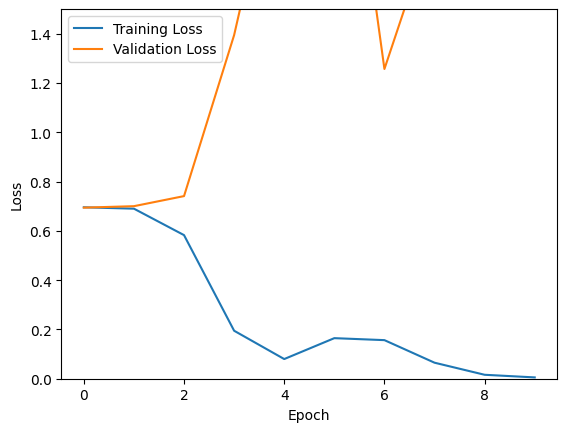

0.6140350877192983


In [ ]:
model, accuracy = train_model(ezPzAttn, 64, 4, 0.005, 24, vis=True)
print(accuracy)

In [ ]:
best_model = model

In [ ]:
torch.save(best_model, './saved_models/bin_attn.pth')

In [ ]:
ezPiezo = ezPzAttn
model = torch.load('./saved_models/bin_attn.pth')
model.to(device).eval()
criterion = nn.CrossEntropyLoss()

predicted_y = []
true_y = []
val_loss = 0
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device=device, dtype=torch.float32)
        val_y = val_y.to(device=device, dtype=torch.long)
        val_scores = model(val_x)
        _, preds = torch.max(val_scores, 1)
        val_scores = model(val_x)
        val_loss += criterion(val_scores, val_y).item()

        if device == torch.device('cuda'):
            predicted_y.extend(preds.cpu().numpy())
            true_y.extend(val_y.cpu().numpy())
        else:
            predicted_y.extend(preds.numpy())
            true_y.extend(val_y.numpy())
    
    val_accuracy = accuracy_score(true_y, predicted_y)
    print(f'Validation Accuracy: {val_accuracy:.2%}')

    average_val_loss = val_loss / len(val_loader)
    print(f'Average Validation Loss: {average_val_loss:.3f}')

Validation Accuracy: 61.40%
Average Validation Loss: 2.031


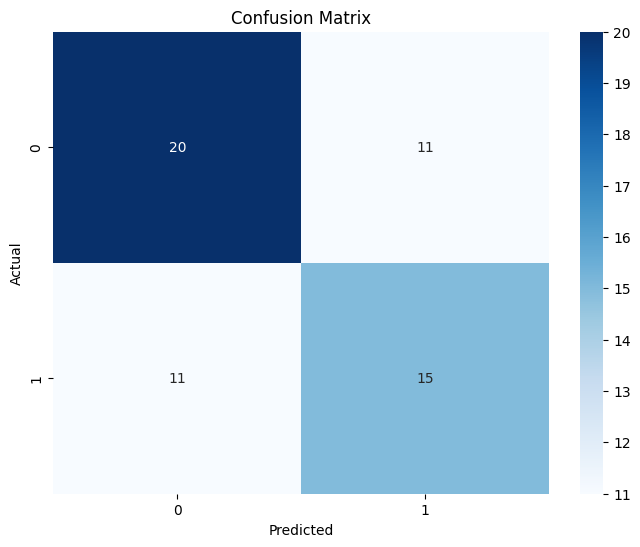

In [ ]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()